Directory of the tests: `/BGFS/DISASTER/grimast/calibration3arcmin_workflow/catchments/4814/`

Experiments:
* `out_Gv5test5_deapup_MCT_TL_RES/long_term_run/`
* `out_Gv5test5_deapup_MCT_TL_RES/long_term_run_FIXreservoirsmodule/`
* `out_deapup_MCT_TL_RESmapspar0303205_RESfix_RFparam/long_term_run_RESFILL/`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from lisflood_read_plot import *

from lisfloodreservoirs.utils.plots import plot_resops, reservoir_analysis

## Config

In [2]:
PATH_TESTS = Path('Z:/nahaUsers/casadje/GloFASv5/reservoirs/tests')

catchment = '4814'
# test = 'out_Gv5test5_deapup_MCT_TL_RES'
test = 'out_deapup_MCT_TL_RESmapspar0303205_RESfix_RFparam/long_term_run_RESFILL'
# test = 'out_deapup_MCT_TL_RESmapspar0303205_RESfix_RFparam/long_term_run_RESFILL_standardparam'
PATH_RESULTS = PATH_TESTS / catchment / test

# PATH_OBS = Path('Z:/nahaUsers/casadje/datasets/Kazakhstan/reservoirs/timeseries/processed')

## Records

In [3]:
# observed = pd.read_csv(PATH_OBS / 'shardara.csv', parse_dates=True, index_col='date')
# observed.rename(columns={'inflow m3/sec': 'inflow', 'discharge m3/sec': 'outflow', 'volume million/m3': 'filling'}, inplace=True)
# observed.filling /= 6700 # 5200 hm3 according to Kazakhstan

# observed.head()

## Model

### Time series

In [42]:
# files to be read
tss_files = {
    'resfill': 'filling2',
    'resfill_wabsON': 'filling1',
    'qresin': 'inflow2',
    'qresin_wabsON': 'inflow1',
    'qresout': 'outflow2',
    'qresout_wabsON': 'outflow1',
    # 'withdrawalReservoirsTS': 'withdrawal'
}

# find settings file
try:
    settings_file = list(PATH_RESULTS.glob('*.xml'))[0]
except:
    settings_file = None

# read results
results = {}
for file, variable in tss_files.items():
    df = read_tss(
        tss=PATH_RESULTS / f'{file}.tss',
        xml=settings_file
    )
    df = df.replace(1e31, np.nan).dropna(axis=1, how='all')
    df.columns = df.columns.astype(int)
    results[variable] = df

# reorganize results
results = {
    ID: pd.concat([df[ID] for df in results.values()], axis=1, keys=results.keys())
    for ID in results[list(results)[0]].columns
}

### Reservoir attributes

In [43]:
attributes = []
for txt_file in (PATH_TESTS  / 'tables' / 'new').glob('reservoirs*20250228.txt'):
    print(txt_file)
    attr = pd.read_csv(txt_file, sep='\t', header=None, index_col=0)
    attr.columns = ['_'.join(txt_file.stem.split('_')[2:-1])]
    attr.index.name = 'ID'
    attributes.append(attr)
attributes = pd.concat(attributes, axis=1)
attributes = attributes.loc[results.keys()]

attributes.head()

Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_100yr_inflow_20250228.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_avg_inflow_20250228.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_capacity_20250228.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\tables\new\reservoirs_glofas5_env_flow_20250228.txt


,100yr_inflow,avg_inflow,capacity,env_flow
ID,,,,
345,8587.1,135.4,3140000000,6.769
1889,1943.2,30.2,278300000,1.512


### Reservoir parameters

In [44]:
parameters = []
for txt_file in (PATH_TESTS  / 'parameters').glob('reservoirs*.txt'):
    print(txt_file)
    par = pd.read_csv(txt_file, sep='\t', header=None, index_col=0)
    par.columns = ['_'.join(txt_file.stem.split('_')[2:])]
    par.index.name = 'ID'
    parameters.append(par)
parameters = pd.concat(parameters, axis=1)
parameters = parameters.loc[results.keys()]

# parameters = pd.DataFrame(index=attributes.index)
# parameters['flood_storage'] = 0.75
# parameters['outflow_factor'] = 0.3

parameters.head()

Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\parameters\reservoirs_glofas5_flood_storage.txt
Z:\nahaUsers\casadje\GloFASv5\reservoirs\tests\parameters\reservoirs_glofas5_outflow_factor.txt


,flood_storage,outflow_factor
ID,,
345,0.647106,0.286453
1889,0.608155,0.266418


### Reservoir limits

In [45]:
limits = pd.DataFrame(index=attributes.index, dtype=float)

limits['Vt'] = 1 # attributes.capacity
limits['Ve'] = 0.8 * limits.Vt + 0.2 * parameters.flood_storage
limits['Vf'] = parameters.flood_storage * limits.Vt
limits['Vc'] = 0.5 * limits.Vf

limits['Qf'] = parameters.outflow_factor *  attributes['100yr_inflow']
limits['Qn'] = attributes.avg_inflow
limits['Qc'] = limits.Qn * limits.Vc / limits.Vf
limits['Qmin'] = attributes.env_flow

limits.head()

,Vt,Ve,Vf,Vc,Qf,Qn,Qc,Qmin
ID,,,,,,,,
345,1,0.929421,0.647106,0.323553,2459.800556,135.4,67.7,6.769
1889,1,0.921631,0.608155,0.304078,517.703458,30.2,15.1,1.512


### Analysis

In [46]:
sim

,filling2,filling1,inflow2,inflow1,outflow1
1979-01-02,0.604065,0.604060,4363.320000,4363.270000,1224.0300
1979-01-03,0.642012,0.641999,2936.650000,2936.460000,1557.5500
1979-01-04,0.644873,0.644851,855.468000,855.203000,751.5090
1979-01-05,0.641906,0.641872,642.794000,642.525000,750.5980
1979-01-06,0.632388,0.632339,374.457000,374.113000,720.3990
...,...,...,...,...,...
2019-12-28,0.351319,0.350830,0.004460,0.004447,73.1594
2019-12-29,0.349326,0.348825,0.003687,0.003662,72.4295
2019-12-30,0.347352,0.346838,0.022426,0.017621,71.7584
2019-12-31,0.345395,0.344868,0.021047,0.009671,71.1441


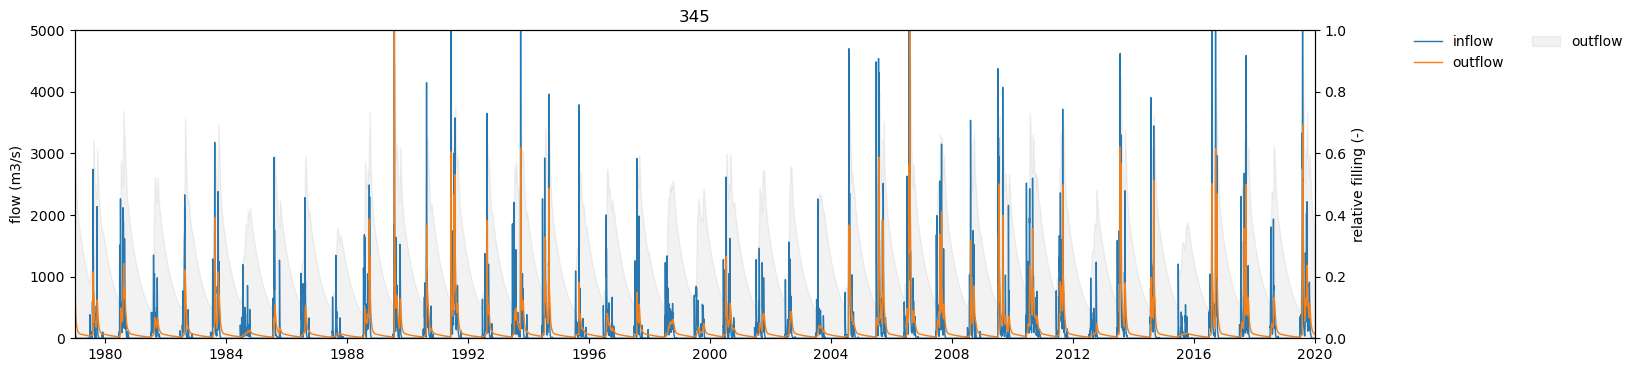

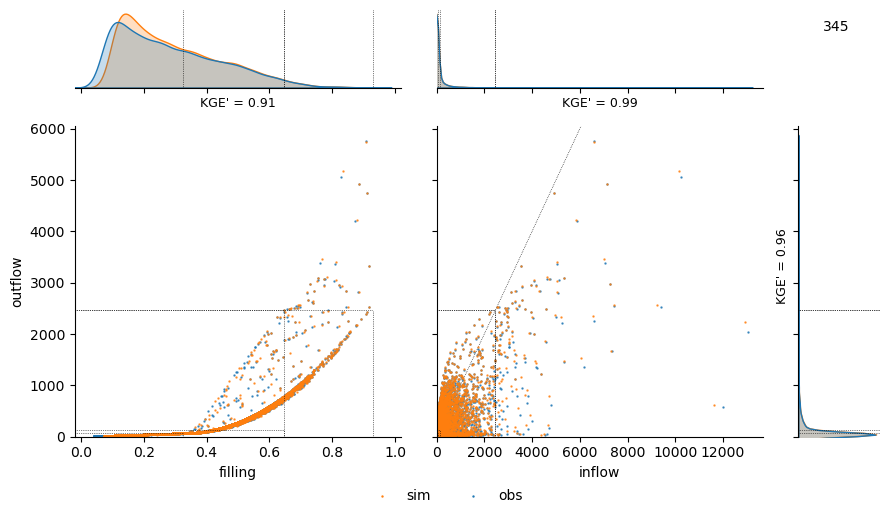

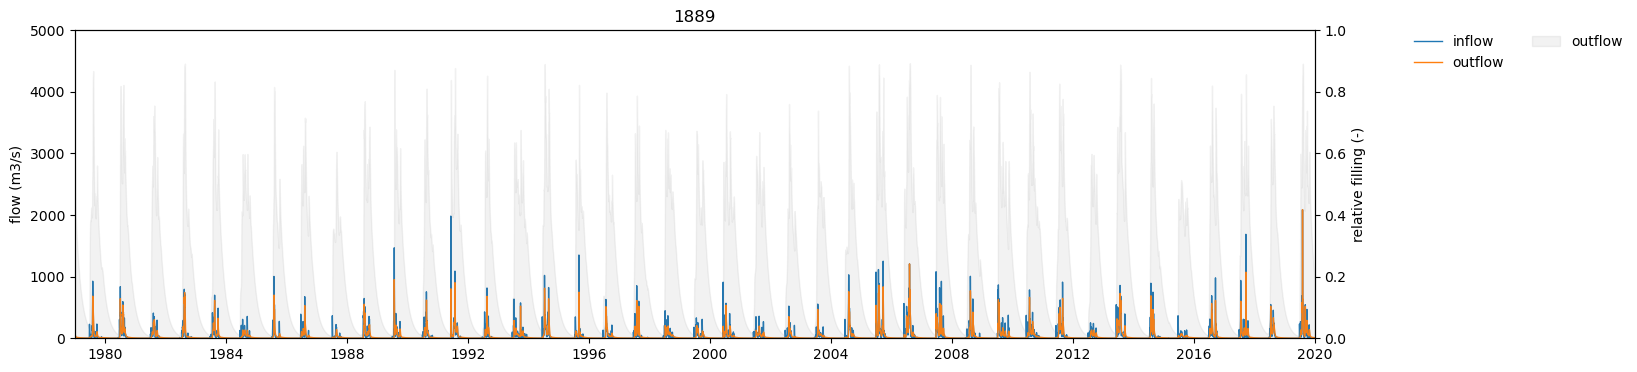

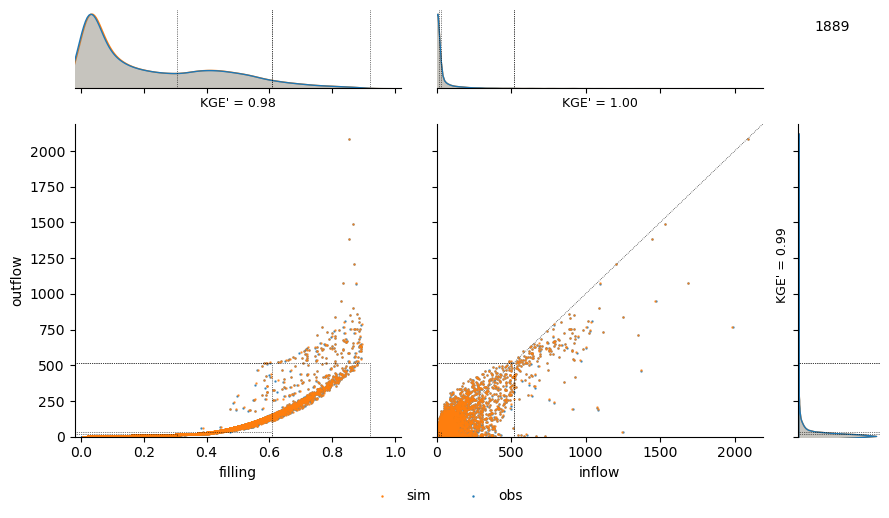

In [50]:
for ID, sim in results.items():
    sim1 = sim[['filling1', 'inflow1', 'outflow1']].copy()
    sim1.columns = ['filling', 'inflow', 'outflow']
    sim2 = sim[['filling2', 'inflow2', 'outflow2']].copy()
    sim2.columns = ['filling', 'inflow', 'outflow']
    plot_reservoir(
        sim2,
        title=ID
    )
    reservoir_analysis(
        sim=sim2,
        obs=sim1,
        x1='filling',
        x_thr=limits.loc[ID, ['Ve', 'Vf', 'Vf', 'Vc']],
        x2='inflow',
        y='outflow',
        y_thr=limits.loc[ID, ['Qf', 'Qf', 'Qn', 'Qc']],
        title=ID,
        alpha=.8
    )

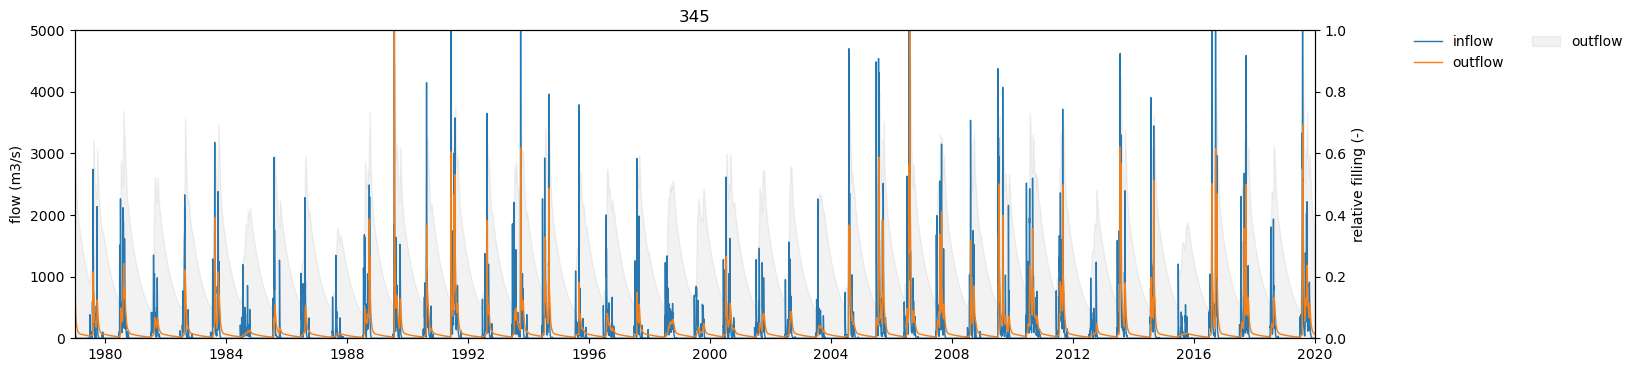

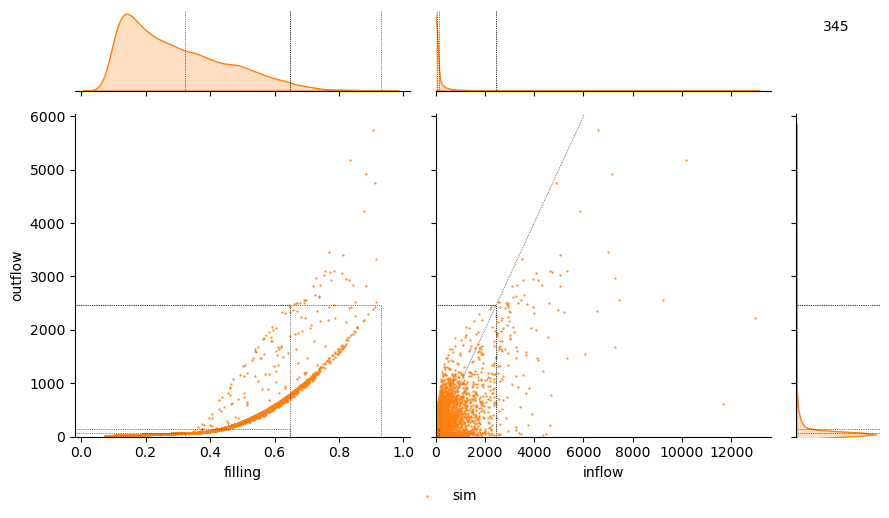

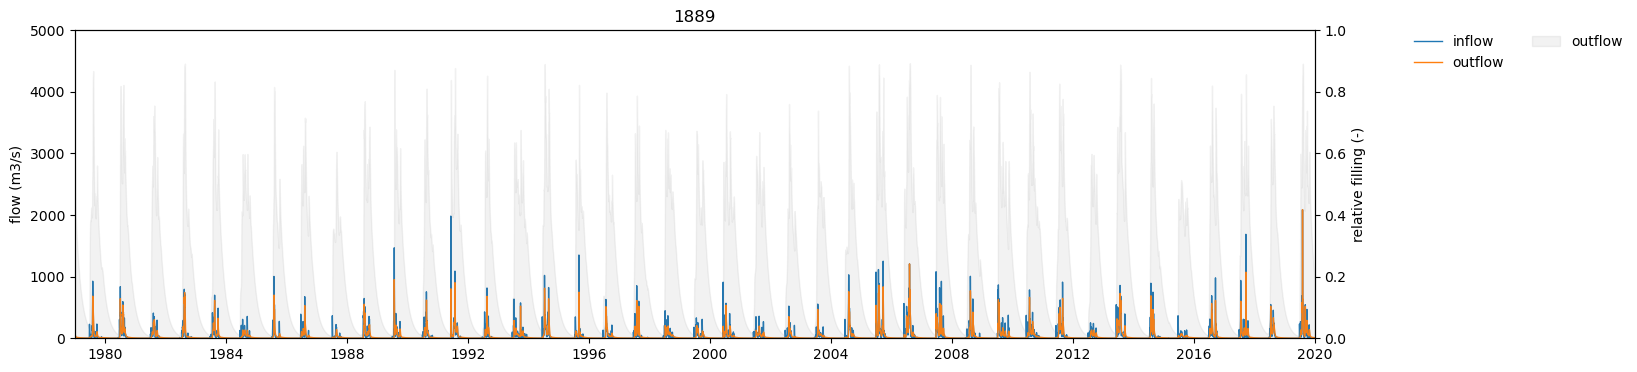

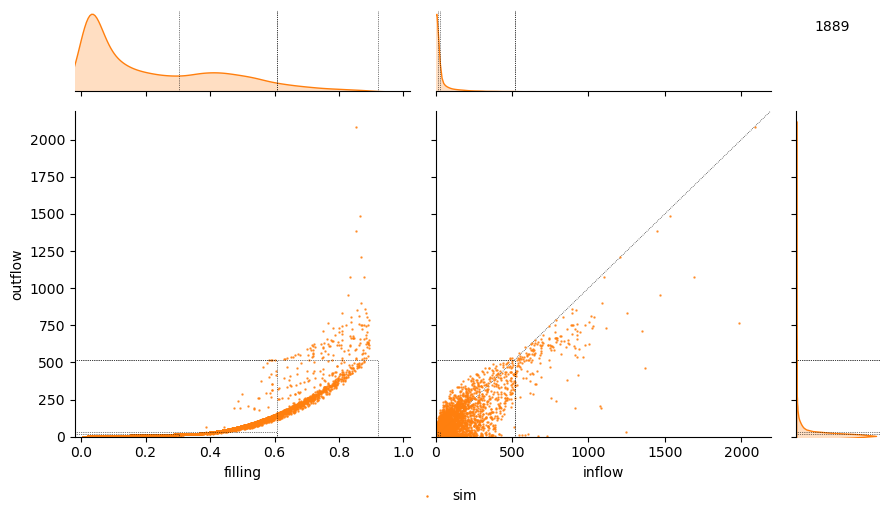

In [29]:
for ID, sim in results.items():
    plot_reservoir(sim, title=ID)
    if ID == 525:
        obs = observed
    else:
        obs = None
    reservoir_analysis(
        sim=sim,
        obs=obs,
        x1='filling',
        x_thr=limits.loc[ID, ['Ve', 'Vf', 'Vf', 'Vc']],
        x2='inflow',
        y='outflow',
        y_thr=limits.loc[ID, ['Qf', 'Qf', 'Qn', 'Qc']],
        title=ID,
        alpha=.8
    )

In [12]:
ID = 345
results[ID].inflow.min(), results[ID].outflow.min(), limits.loc[ID, 'Qmin']

(2.52051e-09, 8.43039, 6.769)